Lambda School Data Science

*Unit 4, Sprint 1, Module 3*

---

# Document Classification (Lecture)

Today's guided module project will be different. You already know how to do classification. And you already know how to extract features from documents. So? That means you're ready to combine and practice those skills in a kaggle competition. We we will open with a five minute sprint explaining the competition, and then give you 25 minutes to work. After those twenty five minutes are up, I will give a 5-minute demo an NLP technique that will help you with document classification (*and **maybe** the competition*).

Today's all about having fun and practicing your skills. The competition will begin

## Learning Objectives
* <a href="#p1">Part 1</a>: Text Feature Extraction & Classification Pipelines
* <a href="#p2">Part 2</a>: Latent Semantic Indexing
* <a href="#p3">Part 3</a>: Word Embeddings with Spacy

# Text Feature Extraction & Classification Pipelines (Learn)
<a id="p1"></a>

## Overview

Sklearn pipelines allow you to stitch together multiple components of a machine learning process. The idea is that you can pass you raw data and get predictions out of the pipeline. This ability to pass raw input and receive a prediction from a singular class makes pipelines well suited for production, because you can pickle a a pipeline without worry about other data preprocessing steps. 

*Note:* Each time we call the pipeline during grid search, each component is fit again. The vectorizer (tf-idf) is transforming our entire vocabulary during each cross-validation fold. That transformation adds significant run time to our grid search. There *might* be interactions between the vectorizer and our classifier, so we estimate their performance together in the code below. However, if your goal is to reduce run time. Train your vectorizer separately (ie out of the grid-searched pipeline). 

In [1]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

### Load Data

In [2]:
# Dataset
categories = ['sci.electronics',
              'rec.sport.baseball',
              'rec.sport.hockey']

# Load training data
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 1788
Testing Samples: 1189


In [3]:
print(newsgroups_train.data[10])




I would have chosen Alex Zhitnik for biggest suprise.  They
did expect that he would become a great defenseman, but I don't
think anyone knew that he was going to be this impressive in his 
rookie year.  His speed, skating ability, and puck control is
exceptional -- he is the one to watch on the Kings.


Kris
kris@fs2.assist.uci.edu

GO KINGS!



In [4]:
newsgroups_train.target[0]

1

In [5]:
newsgroups_train.target_names

['rec.sport.baseball', 'rec.sport.hockey', 'sci.electronics']

### Explore the Data

Building and training a model is only one part of the workflow. Understanding the basic characteristics of your data beforehand will enable you to build a better model. This could mean obtaining higher accuracy, requiring less data for training, or potentially fewer computation resources. 

In [6]:
from explore_data import get_num_words_per_sample 
from explore_data import plot_sample_length_distribution
from explore_data import plot_class_distribution
from explore_data import plot_frequency_distribution_of_ngrams
import seaborn as sns
sns.set()

In [7]:
median_words_per_sample = get_num_words_per_sample(newsgroups_train.data)
print(f'Median words per sample: {median_words_per_sample}')

Median words per sample: 75.0


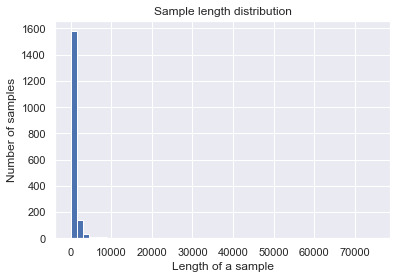

In [8]:
plot_sample_length_distribution(newsgroups_train.data)

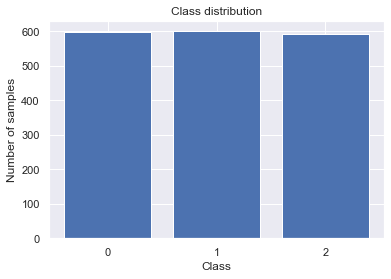

In [9]:
plot_class_distribution(newsgroups_train.target)

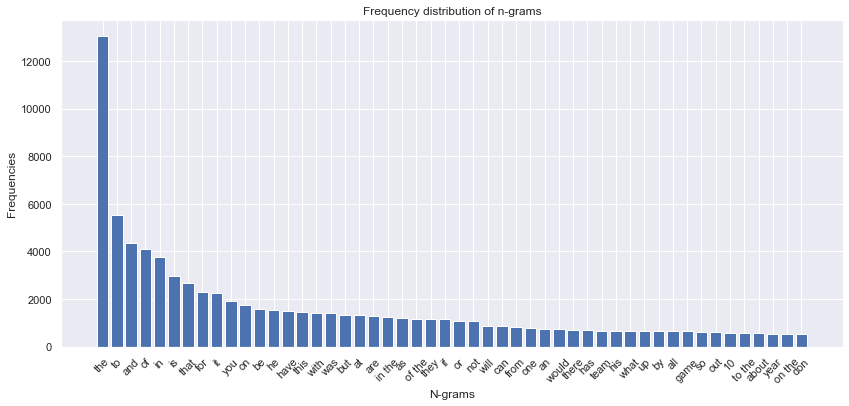

In [10]:
plot_frequency_distribution_of_ngrams(newsgroups_train.data,
                                      ngram_range=(1, 2),
                                      num_ngrams=50)

### Choose a Modeling Approach

Reference: https://developers.google.com/machine-learning/guides/text-classification/step-2-5

At this point, we have assembled our dataset and gained insights into the key characteristics of our data. Next, based on the metrics we gathered we should think about which classification model we should use. This means asking questions such as: 

- “How do we present the text data to an algorithm that expects numeric input?” (Data preprocessing and vectorization)
- “What type of model should we use?”
- “What configuration parameters should we use for our model?”, etc.

In the reference guide above, Google attempts to significantly simplify the process of selecting a text classification model. For a given dataset, our goal is to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training. We ran a large number (~450K) of experiments across problems of different types (especially sentiment analysis and topic classification problems), using 12 datasets, alternating for each dataset between different data preprocessing techniques and different model architectures. This helped us identify dataset parameters that influence optimal choices.

The model selection algorithm and flowchart below are a summary of our experimentation.

In [11]:
sw_ratio = len(newsgroups_train.data) / median_words_per_sample
print(f'Number of Samples / Median Words per Sample ratio: {int(sw_ratio)}')

Number of Samples / Median Words per Sample ratio: 23


![](https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png)

### Build a Baseline TF-IDF Model

In [12]:
# Create Pipeline Components
vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
svm = LinearSVC()

In [13]:
import pandas as pd

# Get sparse dtm
dtm = vect.fit_transform(newsgroups_train.data)

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(1788, 132435)

In [16]:
# Define the Pipeline
pipe = Pipeline([
    ('vect',vect),      # TF-IDF Vectorizer
    ('clf',svm)       # LinearSVC Classifier
])
pipe

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
           

In [17]:
parameters = {
    'vect__max_df': (0.7, 1.0),
    'vect__min_df': (2, 5, 10),
    'vect__max_features': (5000, 20000),
    'clf__penalty': ('l1','l2'),
    'clf__C': (0.1, 0.5, 1., 2.)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(newsgroups_train.data, newsgroups_train.target)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   49.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        no

In [18]:
grid_search.best_score_

0.9144437663333491

In [19]:
grid_search.best_params_

{'clf__C': 0.5,
 'clf__penalty': 'l2',
 'vect__max_df': 0.7,
 'vect__max_features': 20000,
 'vect__min_df': 2}

In [20]:
from sklearn.metrics import accuracy_score

# Evaluate on test data
y_test = grid_search.predict(newsgroups_test.data)
accuracy_score(newsgroups_test.target, y_test)

0.904121110176619

In [21]:
# Extract the vectorizer and model from grid_search pipeline
best_model = grid_search.best_estimator_
vect = best_model.named_steps['vect']
clf = best_model.named_steps['clf']

In [23]:
import eli5

eli5.show_weights(clf, vec=vect, top=20)

C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\keith\.conda\envs\U4-S1-NLP\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## Follow Along 

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model (try using the pipe method I just demoed)

## Challenge

You're trying to achieve 75% Accuracy on your model.

## Latent Semantic Indexing (Learn)
<a id="p2"></a>

## Overview

In [ ]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD

# Use parameters from GridSearch in previous section
vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=...,
                       min_df=..., 
                       max_df=...,
                       max_features=...)

# Add dimensionality reduction
svd = TruncatedSVD(algorithm='randomized',
                   n_iter=10)

# Use parameters from RandomSearch in previous section
clf = LinearSVC(C=..., 
                penalty=...)

In [ ]:
params = {
    'svd__n_components': stats.randint(100, 5000),
}

In [ ]:
pipe = Pipeline([
    ('vect', vect),      # TF-IDF Vectorizer
    ('svd', svd),        # Truncated SVD Dimensionality Reduction
    ('clf', clf)         # LinearSVC Classifier
])

In [ ]:
# Fit
random_search = RandomizedSearchCV(pipe, params, cv=2, n_iter=5, n_jobs=-1, verbose=1)
random_search.fit(newsgroups_train.data, newsgroups_train.target)

In [ ]:
random_search.best_score_

In [ ]:
random_search.best_params_

In [ ]:
# Evaluate on test data
y_test = random_search.predict(newsgroups_test.data)
accuracy_score(newsgroups_test.target, y_test)

## Follow Along
1. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
2. Make a submission to Kaggle 


## Challenge

Continue to apply Latent Semantic Indexing (LSI) to various datasets. 

# Word Embeddings with Spacy (Learn)
<a id="p3"></a>

# Overview

In [ ]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [ ]:
doc = nlp("NLP is awesome!")

In [ ]:
nlp_vector = doc.vector
print(len(nlp_vector))

In [ ]:
nlp_vector

In [ ]:
def get_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

In [ ]:
X = get_word_vectors(newsgroups_train.data)
len(X) == len(newsgroups_train.data)

In [ ]:
X_test = get_word_vectors(newsgroups_test.data)

In [ ]:
rfc.fit(X, newsgroups_train.target)

In [ ]:
# Evaluate on test data
y_test = rfc.predict(X_test)
accuracy_score(newsgroups_test.target, y_test)

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(16, 2),
                    random_state=1)

In [ ]:
clf.fit(X, newsgroups_train.target)

In [ ]:
# Evaluate on test data
y_test = clf.predict(X_test)
accuracy_score(newsgroups_test.target, y_test)

## Follow Along

## Challenge

What you should be doing now:
1. Join the Kaggle Competition
2. Download the data
3. Train a model & try: 
    - Creating a Text Extraction & Classification Pipeline
    - Tune the pipeline with a `GridSearchCV` or `RandomizedSearchCV`
    - Add some Latent Semantic Indexing (lsi) into your pipeline. *Note:* You can grid search a nested pipeline, but you have to use double underscores ie `lsi__svd__n_components`
    - Try to extract word embeddings with Spacy and use those embeddings as your features for a classification model.
4. Make a submission to Kaggle 

# Review

To review this module: 
* Continue working on the Kaggle competition
* Find another text classification task to work on